go to [map visualization](prototype.html)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import fiona
import glob
import contextily as ctx
import json
from tqdm.auto import tqdm
print(glob.glob("data/**"))
print(glob.glob("data/**/**"))

['data\\Christchurch', 'data\\sa2_2020.gdb.zip']
['data\\Christchurch\\New Zealand-christchurch-city_Monthly_Match_2020-11-13.csv', 'data\\Christchurch\\ValuationHubLandUseValuesLGOIMA788408.gdb.zip']


In [2]:
fiona.listlayers('data/Christchurch/ValuationHubLandUseValuesLGOIMA788408.gdb.zip')

['CCCReVal2007', 'CCCReVal2013', 'CCCReVal2016', 'CCCReVal2019']

In [3]:
valuation_layers = {}
RESIDENTIAL = ["RESIDENTIAL - Single Unit excluding bach", "RESIDENTIAL - Multi-unit", "RESIDENTIAL - Bach"]
for layer_name in tqdm(fiona.listlayers('data/Christchurch/ValuationHubLandUseValuesLGOIMA788408.gdb.zip')):
    layer = gp.read_file("data/Christchurch/ValuationHubLandUseValuesLGOIMA788408.gdb.zip", layer=layer_name)
    layer = layer[layer.LandUseDescription.isin(RESIDENTIAL)]
    layer = layer[~layer.geometry.isna()].to_crs(epsg=3857)
    print(layer_name, len(layer))
    valuation_layers[layer_name] = layer
valuation_layers["CCCReVal2019"]

  0%|          | 0/4 [00:00<?, ?it/s]

CCCReVal2007 131310
CCCReVal2013 135402
CCCReVal2016 136810
CCCReVal2019 140957


,ValueId,ValueType,FullStreetNumber,StreetNumber,RoadName,RoadExtension,RoadNameFull,Suburb,HighestAndBestUseDescription,LandUseDescription,CapitalValue,LandValue,ImprovementsValue,NatureOfImprovement,ValuationRollNumber,AlphaID,VisitOrder,GeneralValuationDate,geometry
30,2084009,Revaluation,579,579,HILLS,ROAD,HILLS ROAD,Marshland,Dwelling houses of a fully detached or semi-de...,RESIDENTIAL - Single Unit excluding bach,510000,320000,190000,DWG OBS OI ...,21800,,2500,20190801000000,POINT (19219318.121 -5386280.622)
32,2138703,Revaluation,163,163,QUEEN ELIZABETH II,DRIVE,QUEEN ELIZABETH II DRIVE,Mairehau,Dwelling houses of a fully detached or semi-de...,RESIDENTIAL - Single Unit excluding bach,650000,290000,360000,DWG OBS OI ...,21800,,3000,20190801000000,POINT (19217688.034 -5386509.801)
34,2183021,Revaluation,143,143,WINTERS,ROAD,WINTERS ROAD,Mairehau,Dwelling houses of a fully detached or semi-de...,RESIDENTIAL - Single Unit excluding bach,370000,265000,105000,DWG OI ...,21800,,3102,20190801000000,POINT (19217155.065 -5386518.738)
39,2183022,Revaluation,250,250,PRESTONS,ROAD,PRESTONS ROAD,Marshland,Dwelling houses of a fully detached or semi-de...,RESIDENTIAL - Multi-unit,1330000,335000,995000,DWG OBS OFFICE OI ...,21800,,12300,20190801000000,POINT (19218967.796 -5384615.667)
41,2149568,Revaluation,264,264,PRESTONS,ROAD,PRESTONS ROAD,Marshland,Dwelling houses of a fully detached or semi-de...,RESIDENTIAL - Single Unit excluding bach,425000,205000,220000,DWG OBS OI ...,21800,,12600,20190801000000,POINT (19219195.204 -5384563.285)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174308,2154774,Revaluation,569B,569,HEREFORD,STREET,HEREFORD STREET,Linwood,Ownership home units which may be single store...,RESIDENTIAL - Single Unit excluding bach,340000,132000,208000,FLAT OI ...,22441,,2502,20190801000000,POINT (19221112.876 -5393259.196)
174309,2055045,Revaluation,569C,569,HEREFORD,STREET,HEREFORD STREET,Linwood,Ownership home units which may be single store...,RESIDENTIAL - Single Unit excluding bach,345000,132000,213000,FLAT OI ...,22441,,2503,20190801000000,POINT (19221112.415 -5393234.664)
174310,2023878,Revaluation,54,54,AVONHEAD,ROAD,AVONHEAD ROAD,Avonhead,Dwelling houses of a fully detached or semi-de...,RESIDENTIAL - Single Unit excluding bach,630000,420000,210000,DWG OBS OI ...,21896,,73100,20190801000000,POINT (19209313.805 -5392194.987)
174328,2184313,Revaluation,26,26,LINCOLN,ROAD,LINCOLN ROAD,Hillmorton,Dwelling houses of a fully detached or semi-de...,RESIDENTIAL - Single Unit excluding bach,395000,117000,278000,DWG OBS OI ...,22621,C,45300,20190801000000,POINT (19213329.663 -5396539.452)


Note the lack of land area values. Location is a single point. Makes value per m^2 difficult.  
Could join this with something from LINZ to identify each parcel and get the land area for each property.

In [4]:
def classify_land(land):
    first_five = land[:5]
    if first_five == 'RESID':
        return 'Residential'
    elif first_five == 'COMME':
        return 'Commercial'
    else:
        return 'Other'

# could use this to get all residential valuation stats also
use_layers = {}
for layer_name in tqdm(fiona.listlayers('data/Christchurch/ValuationHubLandUseValuesLGOIMA788408.gdb.zip')):
    layer = gp.read_file("data/Christchurch/ValuationHubLandUseValuesLGOIMA788408.gdb.zip", layer=layer_name)
    layer = layer[~layer.geometry.isna()].to_crs(epsg=3857)
    layer['LandUseSimple'] = layer.LandUseDescription.apply(classify_land)
    print(layer_name, len(layer))
    use_layers[layer_name] = layer
use_layers["CCCReVal2019"]

  0%|          | 0/4 [00:00<?, ?it/s]

CCCReVal2007 154760
CCCReVal2013 166008
CCCReVal2016 172327
CCCReVal2019 174331


,ValueId,ValueType,FullStreetNumber,StreetNumber,RoadName,RoadExtension,RoadNameFull,Suburb,HighestAndBestUseDescription,LandUseDescription,CapitalValue,LandValue,ImprovementsValue,NatureOfImprovement,ValuationRollNumber,AlphaID,VisitOrder,GeneralValuationDate,geometry,LandUseSimple
17,2100813,Revaluation,140,140,PRESTONS,ROAD,PRESTONS ROAD,Redwood,Bare land which has an immediate potential for...,MULTI-USE AT PRIMARY LEVEL - Major use - Vacan...,2220000,2220000,0,FG OI ...,21800,,100,20190801000000,POINT (19217236.338 -5384701.589),Other
18,2034478,Revaluation,180,180,PRESTONS,ROAD,PRESTONS ROAD,Marshland,Bare land which has an immediate potential for...,RESIDENTIAL - Vacant,3200000,3150000,50000,DWG GRANNYFLAT OBS OI ...,21800,,300,20190801000000,POINT (19217735.448 -5384601.084),Residential
19,2130997,Revaluation,190,190,PRESTONS,ROAD,PRESTONS ROAD,Marshland,Bare land which has an immediate potential for...,RESIDENTIAL - Vacant,1630000,1530000,100000,DWG OBS OI ...,21800,,500,20190801000000,POINT (19218017.786 -5384677.334),Residential
20,2100814,Revaluation,849,849,HILLS,ROAD,HILLS ROAD,Marshland,Bare land which has an immediate potential for...,RESIDENTIAL - Vacant,1740000,1700000,40000,DWG FG OBS OI ...,21800,,600,20190801000000,POINT (19218351.880 -5384600.131),Residential
21,2034479,Revaluation,829,829,HILLS,ROAD,HILLS ROAD,Marshland,Bare land which has an immediate potential for...,RESIDENTIAL - Vacant,1600000,1500000,100000,DWG OBS OI ...,21800,,700,20190801000000,POINT (19218220.645 -5384766.518),Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174344,2129026,Revaluation,102,102,MAJOR HORNBROOK,ROAD,MAJOR HORNBROOK ROAD,Mount Pleasant,Vacant land which when developed will have a c...,COMMERCIAL - Vacant,75000,75000,0,None,22901,,28701,20190801000000,POINT (19226634.826 -5398097.350),Commercial
174345,2064198,Revaluation,102A,102,MAJOR HORNBROOK,ROAD,MAJOR HORNBROOK ROAD,Mount Pleasant,Vacant land which when developed will have a c...,COMMERCIAL - Vacant,45000,45000,0,None,22901,,28702,20190801000000,POINT (19226635.826 -5398106.269),Commercial
174346,2171706,Revaluation,104,104,MAJOR HORNBROOK,ROAD,MAJOR HORNBROOK ROAD,Mount Pleasant,Vacant land which when developed will have a c...,COMMERCIAL - Vacant,45000,45000,0,None,22901,,28703,20190801000000,POINT (19226634.757 -5398114.633),Commercial
174347,2057718,Revaluation,104A,104,MAJOR HORNBROOK,ROAD,MAJOR HORNBROOK ROAD,Mount Pleasant,Vacant land which when developed will have a c...,COMMERCIAL - Vacant,45000,45000,0,None,22901,,28704,20190801000000,POINT (19226632.675 -5398123.356),Commercial


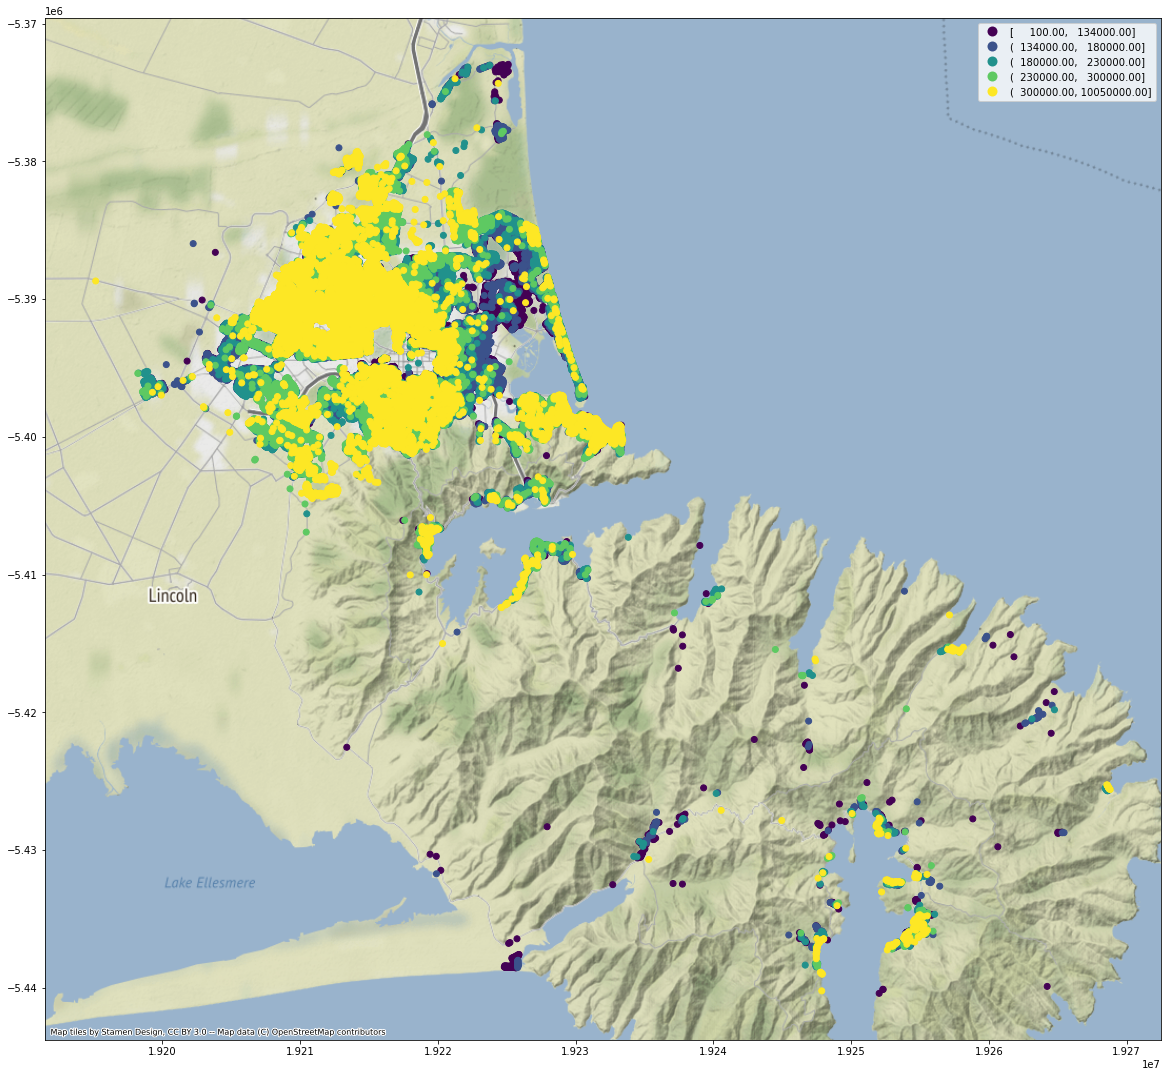

In [5]:
ax = valuation_layers["CCCReVal2019"].sort_values(by="LandValue").plot(column='LandValue', scheme='quantiles', legend=True, figsize=(20,20))
ctx.add_basemap(ax)

In [6]:
df = pd.read_csv("data/Christchurch/New Zealand-christchurch-city_Monthly_Match_2020-11-13.csv")
airbnb = gp.GeoDataFrame(df, geometry=gp.points_from_xy(df.Longitude, df.Latitude))
airbnb = airbnb.set_crs(epsg=4326).to_crs(epsg=3857)
pd.set_option('display.max_columns', None)
airbnb

,Property ID,Property Type,Listing Type,Bedrooms,Reporting Month,Occupancy Rate,Revenue (USD),Revenue (Native),ADR (USD),ADR (Native),Number of Reservations,Reservation Days,Available Days,Blocked Days,Country,State,City,Zipcode,Neighborhood,Metropolitan Statistical Area,Latitude,Longitude,Active,Scraped During Month,Currency Native,Airbnb Property ID,Airbnb Host ID,HomeAway Property ID,HomeAway Property Manager,geometry
0,ab-24564192,Townhouse,Private room,1.0,2018-06-01,0.000,0.0,0.0,NaN,NaN,0,0,30,0,New Zealand,Canterbury,Christchurch City,NaN,NaN,NaN,-43.516066,172.544780,True,True,NZD,24564192.0,185294275.0,NaN,NaN,POINT (19207597.101 -5390855.211)
1,ab-24564192,Townhouse,Private room,1.0,2018-07-01,0.000,0.0,0.0,NaN,NaN,0,0,31,0,New Zealand,Canterbury,Christchurch City,NaN,NaN,NaN,-43.516066,172.544780,True,True,NZD,24564192.0,185294275.0,NaN,NaN,POINT (19207597.101 -5390855.211)
2,ab-24564192,Townhouse,Private room,1.0,2018-08-01,0.000,0.0,0.0,NaN,NaN,0,0,31,0,New Zealand,Canterbury,Christchurch City,NaN,NaN,NaN,-43.516066,172.544780,True,True,NZD,24564192.0,185294275.0,NaN,NaN,POINT (19207597.101 -5390855.211)
3,ab-24564192,Townhouse,Private room,1.0,2018-09-01,0.033,22.0,33.0,22.0,33.0,1,1,29,0,New Zealand,Canterbury,Christchurch City,NaN,NaN,NaN,-43.516066,172.544780,True,True,NZD,24564192.0,185294275.0,NaN,NaN,POINT (19207597.101 -5390855.211)
4,ab-24564192,Townhouse,Private room,1.0,2018-10-01,0.000,0.0,0.0,NaN,NaN,0,0,31,0,New Zealand,Canterbury,Christchurch City,NaN,NaN,NaN,-43.516066,172.544780,False,False,NZD,24564192.0,185294275.0,NaN,NaN,POINT (19207597.101 -5390855.211)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224750,ha-9464818ha,House,Entire home/apt,3.0,2020-06-01,0.000,0.0,NaN,NaN,NaN,0,0,0,30,New Zealand,Canterbury,Christchurch City,NaN,NaN,NaN,-43.560921,172.718826,False,True,NaN,NaN,NaN,9464818ha,NaN,POINT (19226971.761 -5397743.228)
224751,ha-9464818ha,House,Entire home/apt,3.0,2020-07-01,0.000,0.0,NaN,NaN,NaN,0,0,6,25,New Zealand,Canterbury,Christchurch City,NaN,NaN,NaN,-43.560921,172.718826,True,True,NaN,NaN,NaN,9464818ha,NaN,POINT (19226971.761 -5397743.228)
224752,ha-9464818ha,House,Entire home/apt,3.0,2020-08-01,0.000,0.0,NaN,NaN,NaN,0,0,0,31,New Zealand,Canterbury,Christchurch City,NaN,NaN,NaN,-43.560921,172.718826,False,True,NaN,NaN,NaN,9464818ha,NaN,POINT (19226971.761 -5397743.228)
224753,ha-9464818ha,House,Entire home/apt,3.0,2020-09-01,0.000,0.0,NaN,NaN,NaN,0,0,0,30,New Zealand,Canterbury,Christchurch City,NaN,NaN,NaN,-43.560921,172.718826,False,False,NaN,NaN,NaN,9464818ha,NaN,POINT (19226971.761 -5397743.228)


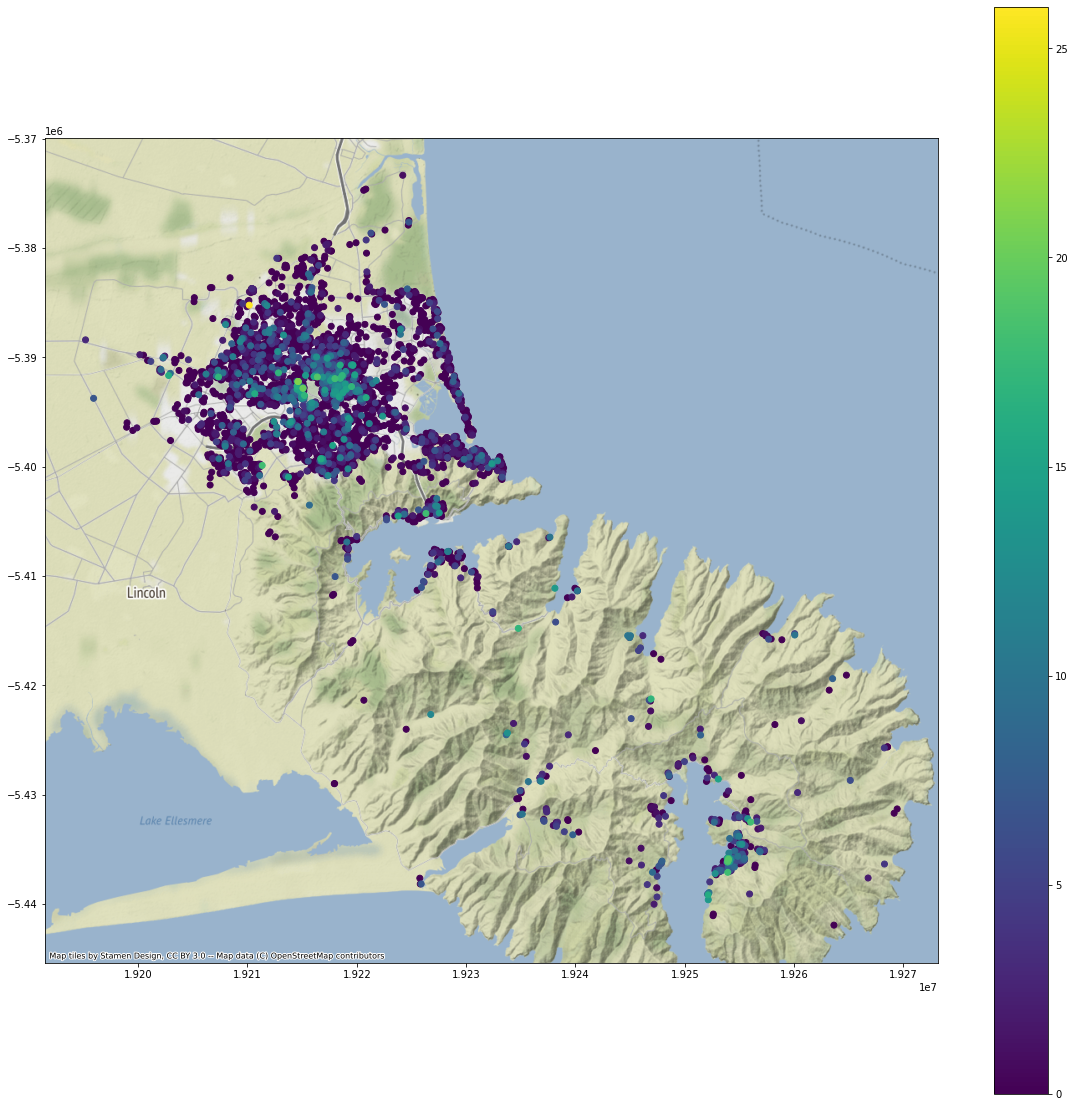

In [7]:
ax = airbnb[airbnb["Reporting Month"] == "2020-10-01"].sort_values(by="Number of Reservations").plot(column='Number of Reservations', legend=True, figsize=(20,20))
ctx.add_basemap(ax)

<AxesSubplot:>

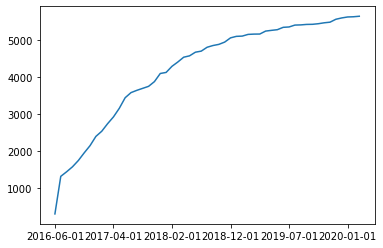

In [8]:
airbnb["Reporting Month"].value_counts().sort_values().plot()

In [9]:
sa2 = gp.read_file("data/sa2_2020.gdb.zip")
sa2

,SA22020_V1_00,SA22020_V1_00_NAME,SA22020_V1_00_NAME_ASCII,LAND_AREA_SQ_KM,AREA_SQ_KM,SHAPE_Length,geometry
0,100100,North Cape,North Cape,829.081715,829.081715,4.159623e+05,"MULTIPOLYGON (((1567022.256 6185741.265, 15670..."
1,100200,Rangaunu Harbour,Rangaunu Harbour,273.936484,273.936484,1.491554e+05,"MULTIPOLYGON (((1624517.242 6128488.368, 16245..."
2,100300,Inlets Far North District,Inlets Far North District,0.000000,626.101124,1.358870e+06,"MULTIPOLYGON (((1666947.690 6126687.578, 16669..."
3,100400,Karikari Peninsula,Karikari Peninsula,174.188105,174.188105,1.400124e+05,"MULTIPOLYGON (((1636163.048 6151520.935, 16361..."
4,100500,Tangonge,Tangonge,177.098445,177.098445,1.013318e+05,"MULTIPOLYGON (((1615865.103 6109920.357, 16154..."
...,...,...,...,...,...,...,...
2250,362300,Kennington-Tisbury,Kennington-Tisbury,36.983390,36.983390,3.881653e+04,"MULTIPOLYGON (((1246757.001 4849353.288, 12467..."
2251,362400,Newfield,Newfield,2.005521,2.005521,6.489263e+03,"MULTIPOLYGON (((1245183.705 4849667.898, 12452..."
2252,362500,Strathern,Strathern,0.983959,0.983959,4.203835e+03,"MULTIPOLYGON (((1243610.148 4848171.365, 12436..."
2253,362600,Elizabeth Park,Elizabeth Park,1.030253,1.030253,5.085466e+03,"MULTIPOLYGON (((1245413.220 4848647.633, 12456..."


In [10]:
sa2 = sa2[~sa2.geometry.isna()].to_crs(epsg=3857)

In [11]:
%%time
joined_val = gp.sjoin(sa2, pd.concat(valuation_layers))
joined_val

Wall time: 58.8 s


,SA22020_V1_00,SA22020_V1_00_NAME,SA22020_V1_00_NAME_ASCII,LAND_AREA_SQ_KM,AREA_SQ_KM,SHAPE_Length,geometry,index_right0,index_right1,ValueId,ValueType,FullStreetNumber,StreetNumber,RoadName,RoadExtension,RoadNameFull,Suburb,HighestAndBestUseDescription,LandUseDescription,CapitalValue,LandValue,ImprovementsValue,NatureOfImprovement,ValuationRollNumber,AlphaID,VisitOrder,GeneralValuationDate
501,316400,McLeans Island,McLeans Island,73.944787,73.944787,58220.693286,"MULTIPOLYGON (((19195825.404 -5383556.919, 191...",CCCReVal2019,20802,2028606,Revaluation,460,460,COUTTS ISLAND,ROAD,COUTTS ISLAND ROAD,Coutts Island,Dwelling houses of a fully detached or semi-de...,RESIDENTIAL - Single Unit excluding bach,430000,150000,280000,DWG OBS OI ...,21916,,47600,20190801000000
501,316400,McLeans Island,McLeans Island,73.944787,73.944787,58220.693286,"MULTIPOLYGON (((19195825.404 -5383556.919, 191...",CCCReVal2007,21729,764852,Revaluation,460,460,COUTTS ISLAND,ROAD,COUTTS ISLAND ROAD,Coutts Island,Dwelling houses of a fully detached or semi-de...,RESIDENTIAL - Single Unit excluding bach,250000,113000,137000,DWG OBS OI,21916,,47600,20070801000000
501,316400,McLeans Island,McLeans Island,73.944787,73.944787,58220.693286,"MULTIPOLYGON (((19195825.404 -5383556.919, 191...",CCCReVal2016,21044,1708857,Revaluation,460,460,COUTTS ISLAND,ROAD,COUTTS ISLAND ROAD,Coutts Island,Dwelling houses of a fully detached or semi-de...,RESIDENTIAL - Single Unit excluding bach,375000,136000,239000,DWG OBS OI ...,21916,,47600,20160801000000
501,316400,McLeans Island,McLeans Island,73.944787,73.944787,58220.693286,"MULTIPOLYGON (((19195825.404 -5383556.919, 191...",CCCReVal2013,21159,1330052,Revaluation,460,460,COUTTS ISLAND,ROAD,COUTTS ISLAND ROAD,Coutts Island,Dwelling houses of a fully detached or semi-de...,RESIDENTIAL - Single Unit excluding bach,340000,124000,216000,DWG OBS OI ...,21916,,47600,20131101000000
501,316400,McLeans Island,McLeans Island,73.944787,73.944787,58220.693286,"MULTIPOLYGON (((19195825.404 -5383556.919, 191...",CCCReVal2013,117173,1440692,Revaluation,63,63,SAVILLS,ROAD,SAVILLS ROAD,Yaldhurst,Dwelling houses of a fully detached or semi-de...,RESIDENTIAL - Single Unit excluding bach,150000,80000,70000,COTTAGE OI ...,23510,,13701,20131101000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2208,332500,Lyttelton,Lyttelton,4.453750,4.453750,23058.016010,"MULTIPOLYGON (((19225605.860 -5403997.088, 192...",CCCReVal2013,143364,1446565,Revaluation,34,34,PARK,TERRACE,PARK TERRACE,Corsair Bay,Dwelling houses of a fully detached or semi-de...,RESIDENTIAL - Single Unit excluding bach,395000,148000,247000,DWG OBS OI ...,23802,,35900,20131101000000
2208,332500,Lyttelton,Lyttelton,4.453750,4.453750,23058.016010,"MULTIPOLYGON (((19225605.860 -5403997.088, 192...",CCCReVal2019,138304,2093780,Revaluation,58,58,PARK,TERRACE,PARK TERRACE,Corsair Bay,Dwelling houses of a fully detached or semi-de...,RESIDENTIAL - Single Unit excluding bach,480000,148000,332000,DWG OBS OI ...,23802,,32100,20190801000000
2208,332500,Lyttelton,Lyttelton,4.453750,4.453750,23058.016010,"MULTIPOLYGON (((19225605.860 -5403997.088, 192...",CCCReVal2016,141567,1672977,Revaluation,58,58,PARK,TERRACE,PARK TERRACE,Corsair Bay,Dwelling houses of a fully detached or semi-de...,RESIDENTIAL - Single Unit excluding bach,480000,141000,339000,DWG OBS OI ...,23802,,32100,20160801000000
2208,332500,Lyttelton,Lyttelton,4.453750,4.453750,23058.016010,"MULTIPOLYGON (((19225605.860 -5403997.088, 192...",CCCReVal2007,144871,850658,Revaluation,58,58,PARK,TERRACE,PARK TERRACE,Corsair Bay,Dwelling houses of a fully detached or semi-de...,RESIDENTIAL - Single Unit excluding bach,402000,185000,217000,DWG OBS OI,23802,,32100,20070801000000


In [12]:
joined_use = gp.sjoin(sa2, pd.concat(use_layers))

In [13]:
%%time
joined_airbnb = gp.sjoin(sa2, airbnb)
joined_airbnb

Wall time: 15.4 s


,SA22020_V1_00,SA22020_V1_00_NAME,SA22020_V1_00_NAME_ASCII,LAND_AREA_SQ_KM,AREA_SQ_KM,SHAPE_Length,geometry,index_right,Property ID,Property Type,Listing Type,Bedrooms,Reporting Month,Occupancy Rate,Revenue (USD),Revenue (Native),ADR (USD),ADR (Native),Number of Reservations,Reservation Days,Available Days,Blocked Days,Country,State,City,Zipcode,Neighborhood,Metropolitan Statistical Area,Latitude,Longitude,Active,Scraped During Month,Currency Native,Airbnb Property ID,Airbnb Host ID,HomeAway Property ID,HomeAway Property Manager
501,316400,McLeans Island,McLeans Island,73.944787,73.944787,58220.693286,"MULTIPOLYGON (((19195825.404 -5383556.919, 191...",78222,ab-9517150,House,Private room,1.0,2016-12-01,NaN,NaN,0.0,NaN,NaN,0,0,0,31,New Zealand,Canterbury,Christchurch City,NaN,NaN,NaN,-43.436686,172.605942,False,False,NZD,9517150.0,31757366.0,NaN,NaN
501,316400,McLeans Island,McLeans Island,73.944787,73.944787,58220.693286,"MULTIPOLYGON (((19195825.404 -5383556.919, 191...",78224,ab-9517150,House,Private room,1.0,2017-02-01,NaN,NaN,0.0,NaN,NaN,0,0,0,28,New Zealand,Canterbury,Christchurch City,NaN,NaN,NaN,-43.436686,172.605942,False,False,NZD,9517150.0,31757366.0,NaN,NaN
501,316400,McLeans Island,McLeans Island,73.944787,73.944787,58220.693286,"MULTIPOLYGON (((19195825.404 -5383556.919, 191...",78221,ab-9517150,House,Private room,1.0,2016-11-01,NaN,NaN,0.0,NaN,NaN,0,0,0,30,New Zealand,Canterbury,Christchurch City,NaN,NaN,NaN,-43.436686,172.605942,False,False,NZD,9517150.0,31757366.0,NaN,NaN
501,316400,McLeans Island,McLeans Island,73.944787,73.944787,58220.693286,"MULTIPOLYGON (((19195825.404 -5383556.919, 191...",78223,ab-9517150,House,Private room,1.0,2017-01-01,NaN,NaN,0.0,NaN,NaN,0,0,0,31,New Zealand,Canterbury,Christchurch City,NaN,NaN,NaN,-43.436686,172.605942,False,False,NZD,9517150.0,31757366.0,NaN,NaN
501,316400,McLeans Island,McLeans Island,73.944787,73.944787,58220.693286,"MULTIPOLYGON (((19195825.404 -5383556.919, 191...",78217,ab-9517150,House,Private room,1.0,2016-07-01,0.0,NaN,0.0,NaN,NaN,0,0,31,0,New Zealand,Canterbury,Christchurch City,NaN,NaN,NaN,-43.436686,172.605942,False,False,NZD,9517150.0,31757366.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2209,332600,Inlet Port Lyttelton,Inlet Port Lyttelton,0.000000,42.650556,79597.384555,"MULTIPOLYGON (((19223488.958 -5405191.966, 192...",125003,ab-16042428,Shared room,Shared room,1.0,2017-02-01,0.0,NaN,NaN,NaN,NaN,0,0,28,0,New Zealand,Canterbury,Christchurch City,NaN,NaN,NaN,-43.633035,172.650412,False,False,USD,16042428.0,77806720.0,NaN,NaN
2209,332600,Inlet Port Lyttelton,Inlet Port Lyttelton,0.000000,42.650556,79597.384555,"MULTIPOLYGON (((19223488.958 -5405191.966, 192...",125013,ab-16042428,Shared room,Shared room,1.0,2017-12-01,0.0,0.0,0.0,NaN,NaN,0,0,31,0,New Zealand,Canterbury,Christchurch City,NaN,NaN,NaN,-43.633035,172.650412,True,True,USD,16042428.0,77806720.0,NaN,NaN
2209,332600,Inlet Port Lyttelton,Inlet Port Lyttelton,0.000000,42.650556,79597.384555,"MULTIPOLYGON (((19223488.958 -5405191.966, 192...",125019,ab-16042428,Shared room,Shared room,1.0,2018-06-01,0.0,0.0,0.0,NaN,NaN,0,0,30,0,New Zealand,Canterbury,Christchurch City,NaN,NaN,NaN,-43.633035,172.650412,False,False,USD,16042428.0,77806720.0,NaN,NaN
2209,332600,Inlet Port Lyttelton,Inlet Port Lyttelton,0.000000,42.650556,79597.384555,"MULTIPOLYGON (((19223488.958 -5405191.966, 192...",125017,ab-16042428,Shared room,Shared room,1.0,2018-04-01,0.0,0.0,0.0,NaN,NaN,0,0,30,0,New Zealand,Canterbury,Christchurch City,NaN,NaN,NaN,-43.633035,172.650412,False,False,USD,16042428.0,77806720.0,NaN,NaN


In [14]:
joined_val["year"] = joined_val.GeneralValuationDate.str.slice(stop=4)
joined_val["year"].value_counts()

2019    140957
2016    136810
2013    135402
2007    131310
Name: year, dtype: int64

In [15]:
joined_use["year"] = joined_use.GeneralValuationDate.str.slice(stop=4)
joined_use["year"].value_counts()

2019    174331
2016    172327
2013    166008
2007    154760
Name: year, dtype: int64

In [16]:
joined_airbnb['year'] = joined_airbnb["Reporting Month"].str.slice(stop=4)
joined_airbnb["year"].value_counts().sort_values()

2016    10432
2017    39854
2020    54467
2018    55946
2019    64056
Name: year, dtype: int64

In [17]:
val_years = sorted(joined_val.GeneralValuationDate.str.slice(stop=4).unique())
use_years = sorted(joined_use.GeneralValuationDate.str.slice(stop=4).unique())
airbnb_years = sorted(joined_airbnb["Reporting Month"].str.slice(stop=4).unique())
print(val_years)
print(use_years)
print(airbnb_years)

['2007', '2013', '2016', '2019']
['2007', '2013', '2016', '2019']
['2016', '2017', '2018', '2019', '2020']


In [18]:
common_ids = [i for i in joined_airbnb.SA22020_V1_00.unique() if i in joined_val.SA22020_V1_00.unique()]

In [19]:
joined_val.columns

Index(['SA22020_V1_00', 'SA22020_V1_00_NAME', 'SA22020_V1_00_NAME_ASCII',
       'LAND_AREA_SQ_KM', 'AREA_SQ_KM', 'SHAPE_Length', 'geometry',
       'index_right0', 'index_right1', 'ValueId', 'ValueType',
       'FullStreetNumber', 'StreetNumber', 'RoadName', 'RoadExtension',
       'RoadNameFull', 'Suburb', 'HighestAndBestUseDescription',
       'LandUseDescription', 'CapitalValue', 'LandValue', 'ImprovementsValue',
       'NatureOfImprovement', 'ValuationRollNumber', 'AlphaID', 'VisitOrder',
       'GeneralValuationDate', 'year'],
      dtype='object')

In [20]:
joined_airbnb.columns

Index(['SA22020_V1_00', 'SA22020_V1_00_NAME', 'SA22020_V1_00_NAME_ASCII',
       'LAND_AREA_SQ_KM', 'AREA_SQ_KM', 'SHAPE_Length', 'geometry',
       'index_right', 'Property ID', 'Property Type', 'Listing Type',
       'Bedrooms', 'Reporting Month', 'Occupancy Rate', 'Revenue (USD)',
       'Revenue (Native)', 'ADR (USD)', 'ADR (Native)',
       'Number of Reservations', 'Reservation Days', 'Available Days',
       'Blocked Days', 'Country', 'State', 'City', 'Zipcode', 'Neighborhood',
       'Metropolitan Statistical Area', 'Latitude', 'Longitude', 'Active',
       'Scraped During Month', 'Currency Native', 'Airbnb Property ID',
       'Airbnb Host ID', 'HomeAway Property ID', 'HomeAway Property Manager',
       'year'],
      dtype='object')

In [31]:
%%time
features = []
simple_land_types = joined_use.LandUseSimple.unique()
sa2 = sa2.to_crs(epsg=4326)
for id in tqdm(common_ids):
    print(id)
    name, geo = sa2[sa2.SA22020_V1_00 == id].iloc[0][["SA22020_V1_00_NAME", "geometry"]]
    valuations = {}
    airbnbs = {}
    uses = {}
    for year in val_years:
        df = joined_val[(joined_val.SA22020_V1_00 == id) & (joined_val.year == year)]
        valuations[year] = {
          "LandValue": dict(df.LandValue.describe().replace(np.nan, None)), # NaN is not valid in JSON
          "CapitalValue": dict(df.CapitalValue.describe().replace(np.nan, None)),
        }

    for year in airbnb_years:
        df = joined_airbnb[(joined_airbnb.SA22020_V1_00 == id) & (joined_airbnb.year == year)]
        airbnbs[year] = {
          "RevenueNZD": dict(df["Revenue (Native)"].describe().replace(np.nan, None)),
          "ReservationDays": dict(df["Reservation Days"].describe().replace(np.nan, None)),
          "AvailableDays": dict(df["Available Days"].describe().replace(np.nan, None)),
          "Active": {"count": sum(df["Reservation Days"] > 0)} # define active as having at least 1 reservation day
        }
        airbnbs[year]["ReservationDays"]["sum"] = sum(df["Reservation Days"]) # add total days booked
        if np.isnan(airbnbs[year]["ReservationDays"]["sum"]):
            airbnbs[year]["ReservationDays"]["sum"] = None
        airbnbs[year]["RevenueNZD"]["sum"] = sum(df["Revenue (Native)"])
        if np.isnan(airbnbs[year]["RevenueNZD"]["sum"]):
            airbnbs[year]["RevenueNZD"]["sum"] = None

    for year in use_years:
        df = joined_use[(joined_use.SA22020_V1_00 == id) & (joined_use.year == year)]
        uses[year] = {}
        for land_type in simple_land_types:
            uses[year][land_type] = sum(df["LandUseSimple"] == land_type) / max(len(df["LandUseSimple"]), 1)

    features.append({
      "type": "Feature",
      "geometry": geo.__geo_interface__,
      "properties": {
          "id": id,
          "name": name,
          "valuations": valuations,
          "airbnbs": airbnbs,
          "uses": uses
      }
    })
print(len(features))

  0%|          | 0/168 [00:00<?, ?it/s]

316400
316500
317100
317200
322100
322700
324400
325200
325900
326000
326300
328400
329700
330500
331600
332300
332800
332900
333100
333200
333300
329000
329100
329200
329300
329400
329500
329600
330000
330100
330200
331000
330300
330400
330600
330700
330800
330900
331100
331200
331300
331400
331500
331700
331800
331900
332000
332100
318900
332200
332400
319000
319700
332700
333500
319800
322400
317500
317600
317700
317800
317900
318000
318100
318200
323100
319900
323800
320000
323900
320100
320500
318300
316600
316700
317000
317300
317400
318800
316800
316900
318400
318500
318600
318700
319100
319200
319300
319400
319500
319600
320200
320300
320400
320600
320700
320800
320900
321000
321100
321200
321300
321400
321500
321600
321700
321800
321900
322000
322200
322300
326400
322500
322600
322800
322900
323000
323200
323300
323400
323500
323600
323700
324000
324100
324200
324300
324500
324600
324700
324800
325000
325100
325300
325400
325500
325600
325700
325800
326100
326500
326600
326700

In [32]:
features[-1]

{'type': 'Feature',
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [(((172.70655590056225, -43.60161718318273),
     (172.70606830088656, -43.59912458342277),
     (172.70805798317986, -43.59894561638606),
     (172.7098016668995, -43.59874758337861),
     (172.71191901645312, -43.59853078382063),
     (172.71244956575603, -43.59751296522569),
     (172.71241363415635, -43.59730846644048),
     (172.712425366431, -43.597277083207),
     (172.71237220169021, -43.597113125415454),
     (172.71350723418035, -43.59470048343456),
     (172.71437306805154, -43.594960053192096),
     (172.71510996992524, -43.595170337833395),
     (172.71656123328702, -43.595595733418236),
     (172.71698165007322, -43.59490059972962),
     (172.7171151328663, -43.59493546639951),
     (172.72048334117736, -43.59581718279995),
     (172.72229407007018, -43.59208355202823),
     (172.72296736495318, -43.59254750988496),
     (172.72254644950632, -43.59339431613738),
     (172.72280621609704, -43.593905

In [33]:
geojson = {
  "type": "FeatureCollection",
  "features": features
}
with open('Christchurch.geojson', 'w') as f:
    json.dump(geojson, f)
!ls -lah *.geojson

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!dir *.geojson